In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot  as plt
import seaborn as sns
from sqlalchemy import create_engine


In [2]:
import sqlite3
conn = sqlite3.connect("zomato_project.db")

In [3]:
folder = r"C:\Users\hp\Desktop\zomato_project_data"

In [4]:
for file in os.listdir(folder):
    if file.endswith(".csv"):
        path = os.path.join(folder, file)
        df = pd.read_csv(path)
        df.columns = [c.strip().replace(" ", "_") if c.strip() else f"col_{i}" for i, c in enumerate(df.columns)]
        table = file.replace(".csv", "")
        df.to_sql(table, conn, index=False, if_exists='replace')
        print(f"✅ Uploaded: {table} → {df.shape}")
        
conn.close()

✅ Uploaded: customers → (20000, 5)
✅ Uploaded: orders → (50000, 5)
✅ Uploaded: order_items → (80000, 5)
✅ Uploaded: payments → (50000, 5)
✅ Uploaded: restaurants → (2000, 5)


In [5]:
conn = sqlite3.connect("zomato_project.db")

df_sample = pd.read_sql("SELECT * FROM orders LIMIT 5;", conn)
print(df_sample.columns)
print(df_sample.head())



Index(['order_id', 'customer_id', 'restaurant_id', 'order_date',
       'delivery_time_min'],
      dtype='object')
   order_id customer_id restaurant_id        order_date  delivery_time_min
0  ORD10000    CUST1126       REST773  2024-07-13 01:04                 77
1  ORD10001   CUST17765       REST448  2025-03-11 04:35                 71
2  ORD10002   CUST10235      REST1914  2024-10-25 10:28                 65
3  ORD10003   CUST14581       REST363  2025-02-14 01:23                 53
4  ORD10004    CUST1349      REST1327  2025-06-17 06:38                 59


In [6]:
df_tables = pd.read_sql("SELECT name FROM sqlite_master WHERE type='table';", conn)
print(df_tables)
pd.read_sql("PRAGMA table_info(restaurants);", conn)

          name
0    customers
1       orders
2  order_items
3     payments
4  restaurants


,cid,name,type,notnull,dflt_value,pk
0,0,restaurant_id,TEXT,0,None,0
1,1,name,TEXT,0,None,0
2,2,city,TEXT,0,None,0
3,3,cuisine,TEXT,0,None,0
4,4,rating,REAL,0,None,0


# Which are the Top 5 Restaurants with the Most Orders

In [7]:
query = """
SELECT 
    r.name AS restaurant_name,
    COUNT(o.customer_id) AS total_orders
FROM orders o
JOIN restaurants r
    ON o.restaurant_id = r.restaurant_id
GROUP BY r.name
ORDER BY total_orders DESC
LIMIT 5;
"""

df_top_restaurants = pd.read_sql(query, conn)
print(df_top_restaurants)


  restaurant_name  total_orders
0     Johnson Ltd           118
1      Miller PLC           107
2       Cross PLC            88
3       Smith LLC            85
4     Brown Group            84


# Which city has the worst average delivery time



In [8]:
query = """
SELECT r.city, AVG(o.delivery_time_min) AS average_delivery_time
FROM orders o
JOIN restaurants r ON o.restaurant_id = r.restaurant_id
GROUP BY r.city
ORDER BY average_delivery_time DESC
"""

df_top_orders = pd.read_sql(query, conn)
print(df_top_orders)

                   city  average_delivery_time
0            Holmesfurt              67.538462
1             Lake Lisa              66.869565
2            Leslieport              66.615385
3       South Elizabeth              66.611111
4           Michaelbury              66.416667
...                 ...                    ...
1856         East Bruce              42.666667
1857        Stewartview              42.650000
1858       Gilbertville              41.740741
1859  South Briannaberg              39.315789
1860        New Rebecca              37.062500

[1861 rows x 2 columns]


# Which customers are spending the most money

In [9]:
query = """
SELECT 
    c.customer_id,
    c.name,
    SUM(p.amount) AS total_spent
FROM payments p
JOIN orders o ON p.order_id = o.order_id
JOIN customers c ON o.customer_id = c.customer_id
GROUP BY c.customer_id, c.name
ORDER BY total_spent DESC
"""

df_top_customers = pd.read_sql(query, conn)
print(df_top_customers)

      customer_id                 name  total_spent
0       CUST19660           Todd Sharp       538.90
1        CUST3704           Barry Peck       505.86
2       CUST10511         Scott Garcia       448.20
3       CUST12682          Julia Perry       432.84
4        CUST1066     Jennifer Sanchez       420.94
...           ...                  ...          ...
15843    CUST9522         Kyle Mendoza         5.07
15844    CUST4526       Sabrina Fields         5.06
15845   CUST19113          James Smith         5.05
15846   CUST17069  Elizabeth Hernandez         5.04
15847   CUST11821       Matthew Wilson         5.02

[15848 rows x 3 columns]


# Which cuisines are the most popular

In [12]:
query = """
SELECT 
    r.cuisine, 
    COUNT(*) AS total_orders
FROM orders o
JOIN restaurants r 
    ON o.restaurant_id = r.restaurant_id
GROUP BY r.cuisine
ORDER BY total_orders DESC
"""

df_top_cuisines = pd.read_sql(query, conn)
print(df_top_cuisines)

    cuisine  total_orders
0   Italian          8909
1   Mexican          8817
2      Thai          8615
3   Chinese          8340
4    Indian          8088
5  American          7231


In [16]:
query = """
SELECT 
    r.restaurant_id,
    r.name AS restaurant_name,
    ROUND(r.rating, 2) AS avg_rating,
    COUNT(o.order_id) AS total_orders
FROM restaurants r
LEFT JOIN orders o 
    ON r.restaurant_id = o.restaurant_id
GROUP BY r.restaurant_id, r.name, r.rating
ORDER BY avg_rating ASC, total_orders DESC
"""

df_low_rated = pd.read_sql(query, conn)
print(df_low_rated)

     restaurant_id  restaurant_name  avg_rating  total_orders
0         REST1785     Boyd-Johnson         2.5            38
1         REST1818     Wilkins-Sims         2.5            36
2         REST1402       Garcia Inc         2.5            33
3         REST1903      Mack-Garner         2.5            33
4          REST155     Thompson PLC         2.5            32
...            ...              ...         ...           ...
1995       REST152       Steele Inc         5.0            19
1996      REST1918   Ramirez-Howard         5.0            18
1997       REST261         Soto LLC         5.0            18
1998       REST640  Osborne-Manning         5.0            17
1999      REST1013        Reyes LLC         5.0            15

[2000 rows x 4 columns]


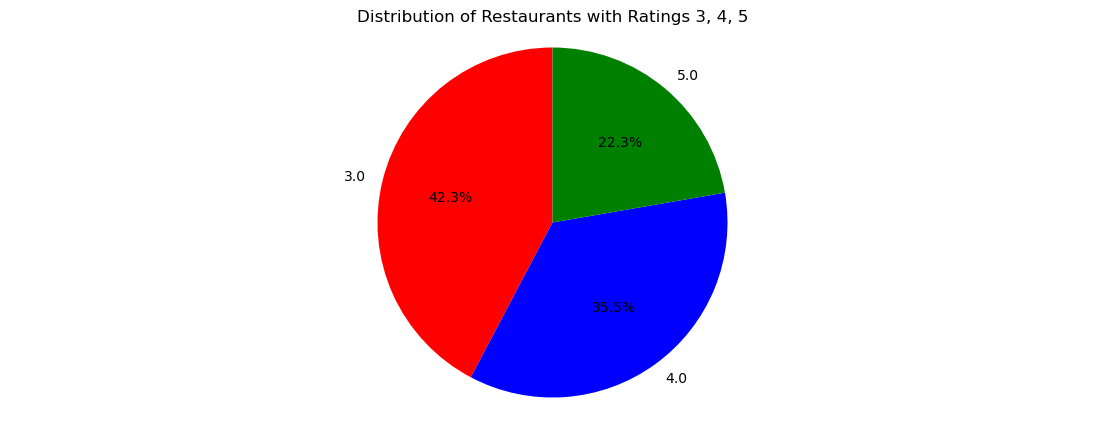

In [38]:
df = df_low_rated[df_low_rated['avg_rating'].isin([3, 4, 5])]

rating_counts = df['avg_rating'].value_counts().sort_index()

plt.figure(figsize=(14,5))
plt.pie(rating_counts, labels=rating_counts.index,
        autopct='%1.1f%%', startangle=90, colors=['r','b','g'])
plt.title('Distribution of Restaurants with Ratings 3, 4, 5')
plt.axis('equal')  

plt.show()